In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing modules

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from keras.utils import to_categorical 
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

In [ ]:
train_dir =  ('/content/drive/MyDrive/Eye')

In [ ]:
datagen_kwargs = dict(rescale = 1./255, validation_split = 0.20, rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True,
fill_mode='nearest',
brightness_range=[0.6,1.4],
zoom_range=0.3)
from keras.applications.resnet50 import preprocess_input

In [ ]:
IMAGE_SHAPE = (224,224)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
train_dir,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE,

)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
train_dir,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE,
)

Found 156 images belonging to 3 classes.
Found 629 images belonging to 3 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 3))

In [ ]:
label_batch[0:5]
print(train_generator.class_indices)

{'Closed': 0, 'Eye': 1, 'NotEye': 2}


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

Closed
Eye
NotEye

In [ ]:
import tensorflow_hub as hub
from keras.applications.resnet50 import ResNet50
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense


model = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4", 
 output_shape=[2048],
 trainable=False),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(1024, activation = 'relu'),
 tf.keras.layers.Dropout(0.6),
 tf.keras.layers.Dense(512, activation = 'relu'),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(256, activation = 'relu'),
 tf.keras.layers.Dropout(0.3),
 tf.keras.layers.Dense(128, activation = 'relu'),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(3, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 2048)              42626560  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)              

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator, 
epochs=30,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/30
20/20 [==============================] - 26s 943ms/step - loss: 1.6965 - acc: 0.3297 - val_loss: 1.1538 - val_acc: 0.3910
Epoch 2/30
20/20 [==============================] - 17s 868ms/step - loss: 1.4440 - acc: 0.4074 - val_loss: 0.9793 - val_acc: 0.4872
Epoch 3/30
20/20 [==============================] - 17s 856ms/step - loss: 1.1866 - acc: 0.4758 - val_loss: 0.8689 - val_acc: 0.6154
Epoch 4/30
20/20 [==============================] - 17s 866ms/step - loss: 1.1183 - acc: 0.4943 - val_loss: 0.7829 - val_acc: 0.6282
Epoch 5/30
20/20 [==============================] - 17s 854ms/step - loss: 1.0836 - acc: 0.5206 - val_loss: 0.7327 - val_acc: 0.6410
Epoch 6/30
20/20 [==============================] - 17s 866ms/step - loss: 0.9871 - acc: 0.5774 - val_loss: 0.6083 - val_acc: 0.7500
Epoch 7/30
20/20 [==============================] - 17s 841ms/step - loss: 0.9551 - acc: 0.5967 - val_loss: 0.5963 - val_acc: 0.7628
Epoch 8/30
20/20 [==============================] - 17s 864ms/step - 

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

5/5 [==============================] - 5s 931ms/step - loss: 0.0369 - acc: 0.9872
Final loss: 0.04
Final accuracy: 98.72%


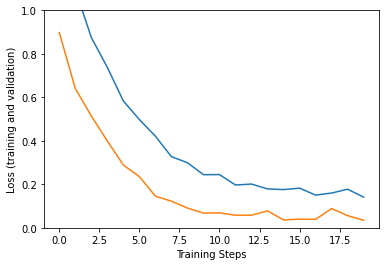

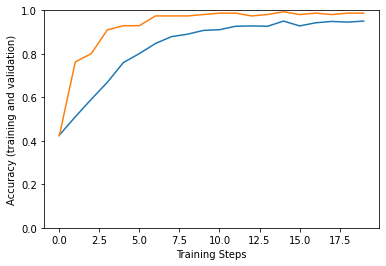

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Closed' 'Eye' 'Noteye']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)
print(tf_model_predictions)

Prediction results shape: (32, 3)
[[2.69936572e-04 3.06222006e-04 9.99423862e-01]
 [3.56880464e-02 4.34310853e-01 5.30001104e-01]
 [1.33739680e-03 9.98613238e-01 4.94501655e-05]
 [1.56151127e-05 7.35163894e-06 9.99976993e-01]
 [6.36099093e-03 9.93323624e-01 3.15317680e-04]
 [9.83912528e-01 9.51014552e-03 6.57733157e-03]
 [5.36063046e-04 9.99430120e-01 3.38668360e-05]
 [6.20932624e-05 7.67444435e-05 9.99861121e-01]
 [9.96463478e-01 1.27891207e-03 2.25762278e-03]
 [9.85334754e-01 9.17764008e-03 5.48762456e-03]
 [1.00280605e-02 9.89756286e-01 2.15674809e-04]
 [1.62441079e-02 2.02677492e-02 9.63488162e-01]
 [3.38415644e-04 9.99656320e-01 5.26813164e-06]
 [1.76300382e-05 9.99981999e-01 3.95362633e-07]
 [9.99576271e-01 9.61104233e-05 3.27609014e-04]
 [9.99899030e-01 6.19192142e-05 3.91421199e-05]
 [5.26260446e-05 2.46454991e-04 9.99700904e-01]
 [3.02744156e-05 9.99967694e-01 2.07577818e-06]
 [9.61473584e-03 3.65613215e-02 9.53823984e-01]
 [9.99911666e-01 7.16062423e-05 1.66483551e-05]
 [9.98

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Noteye' 'Noteye' 'Eye' 'Noteye' 'Eye' 'Closed' 'Eye' 'Noteye' 'Closed'
 'Closed' 'Eye' 'Noteye' 'Eye' 'Eye' 'Closed' 'Closed' 'Noteye' 'Eye'
 'Noteye' 'Closed' 'Closed' 'Noteye' 'Eye' 'Eye' 'Closed' 'Closed' 'Eye'
 'Noteye' 'Closed' 'Eye' 'Eye' 'Eye']


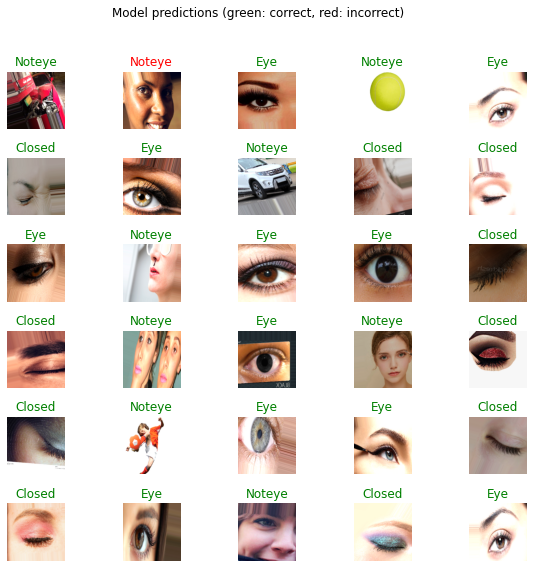

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
model.save('/content/drive/MyDrive/Eye/eye_detection_model.h5 ')

NameError: ignored

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Eye/eye_detection_model.h5 ')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              42626560  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [ ]:
from keras.preprocessing.image import load_img
IMAGE_SHAPE = (224,224)
image = load_img('/content/drive/MyDrive/Eye Classification /test/noteye/JFP06602_4_sml.jpg', target_size=IMAGE_SHAPE)

from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

image = np.expand_dims(image,axis=0)
image = np.array(image)/255.0
print(image.shape)

pred = model.predict(image)
print(pred.shape)
print (pred)


(1, 224, 224, 3)
(1, 3)
[[0.14127328 0.074307   0.7844197 ]]
